<a href="https://colab.research.google.com/github/NotAndex/Demo/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Anomaly (Fraud) Detection with autoencoder (work in progress)

Inpired by:
* the use-case of  [Credit Card Fraud Detection (Kaggle)](https://www.kaggle.com/mlg-ulb/creditcardfraud) on [TensorFlow](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#plot_the_auprc)
* [Autoencoder](https://www.tensorflow.org/tutorials/generative/autoencoder) architecture proposed for Anomaly detection on TensorFlow
 

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

import random as rn

RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [2]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.rename(columns={'Class': 'label'}, inplace=True)
df['log10_amount'] = np.log10(df.Amount + 0.00001)

print(f'Observations of fraud: {len(df.loc[df.label == 1])} == {format(len(df.loc[df.label == 1])/len(df)*100)}% of all observations: {len(df)}')


Observations of fraud: 492 == 0.1727485630620034% of all observations: 284807


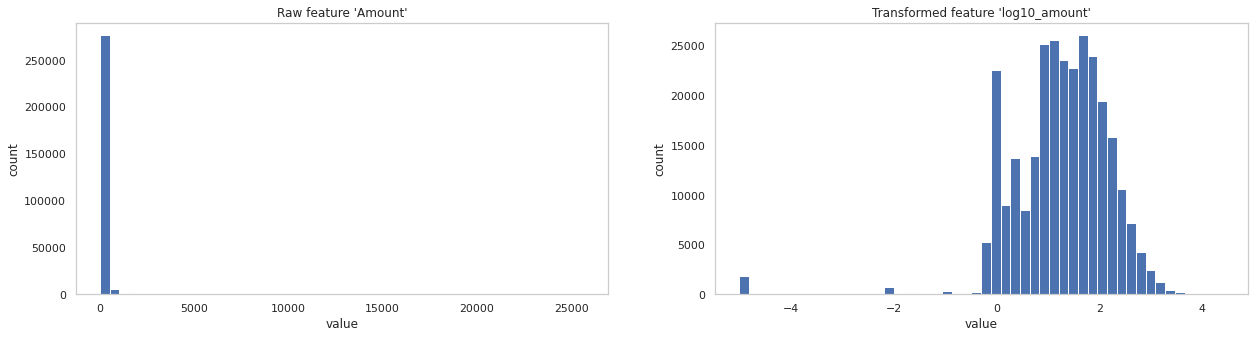

In [22]:
#@title
mpl.rcParams['figure.figsize'] = (21, 5)
mpl.rcParams['axes.grid'] = False

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(df.Amount, bins=50, label="Amount", alpha=1, color="b")
ax1.set_title("Raw feature 'Amount'")
ax1.set(xlabel="value",ylabel="count")

ax2.hist(df.log10_amount, bins=50, label="log10_amount", alpha=1, color="b")
ax2.set_title("Transformed feature 'log10_amount'")
ax2.set(xlabel="value",ylabel="count")

fig.show()

In [ ]:
df = df.drop(['Time','Amount'],axis=1)

fraud_df = df[df.label == 1]
clean_df = df[df.label == 0]

In [ ]:
len_df = len(df)
len_train = int(len(df)*.7)

clean_df = clean_df.sample(frac=1).reset_index(drop=True)

X_train = clean_df.iloc[:len_train].drop('label', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = clean_df.iloc[len_train:].append(fraud_df).sample(frac=1)

In [ ]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=.2, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values



In [ ]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [ ]:
pipeline.fit(X_train)

Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))],
         verbose=False)

In [ ]:
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

In [ ]:
# Load the extension and start TensorBoard
#%tensorboard --logdir logs

In [ ]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

In [ ]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    histogram_freq=1
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

In [ ]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
)

In [ ]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

In [ ]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
print(mse)

[0.01754633 0.01352249 0.00338585 ... 0.01451256 0.00654141 0.01453154]


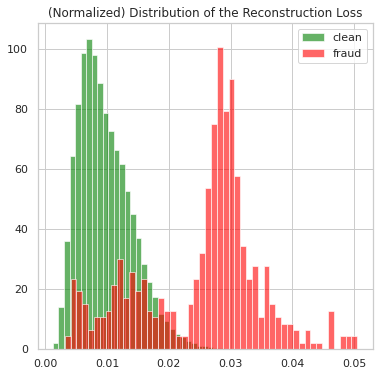

In [ ]:
clean = mse[y_test==0]
fraud = mse[y_test==1]
%matplotlib inline
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()


In [ ]:
THRESHOLD = 3

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [ ]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [ ]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:
[[84034   917]
 [  145   347]]

% of transactions labeled as fraud that were correct (precision): 347/(917+347) = 27.45%
% of fraudulent transactions were caught succesfully (recall):    347/(145+347) = 70.53%


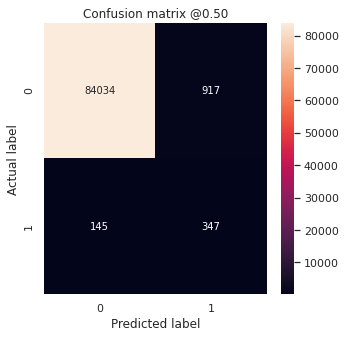

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

plot_cm(y_test,outliers)

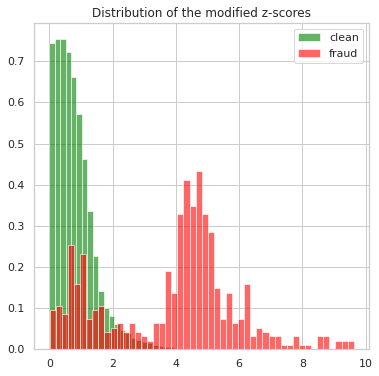

In [ ]:
clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()